In [1]:
from google.colab import drive
drive.mount('/content/drive')
working_path = '/content/drive/MyDrive/Colab Notebooks/torchtorch/'

Mounted at /content/drive


In [ ]:
pip install fastai --upgrade

In [ ]:
pip uninstall folium

In [ ]:
pip install folium==0.2.1

In [5]:
import os
os.chdir(working_path)

In [ ]:
pip install -Uqq fastbook

In [7]:
from fastbook import *

# 최신 모델의 학습 방법
정규화, 믹스업(Mixup), 점진적 크기 조절 기법 등등

사용 이미지 : Imagenette (ImageNet 데이터 중 매우 다른 범주 10개만으로 구성된 데이터셋)

사전학습은 사용하지 않음

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [9]:
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE)

In [13]:
dblock = DataBlock(blocks = (ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label, 
                   # 사전 크기 조절
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path,bs=64)

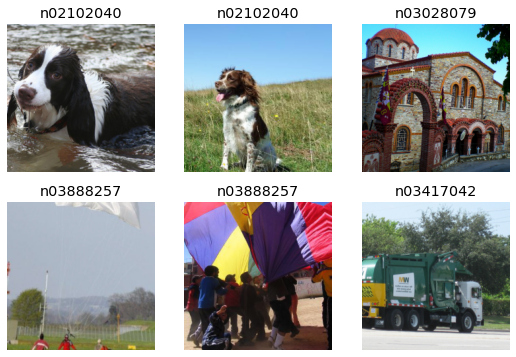

In [15]:
dls.show_batch(nrows=2,ncols=3)

In [14]:
# 기준으로 삼을 모델
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(),metrics=accuracy)
learn.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.553387,3.029349,0.373786,03:04
1,1.178036,1.541015,0.523898,03:07
2,0.895531,1.181870,0.656833,03:08
3,0.710241,0.633171,0.804705,03:05
4,0.592166,0.576272,0.816654,03:05


사전 학습되지 않은 밑바닥에서부터 모델을 새로 만들거나, 사전 학습된 모델을 사용하기는 하지만 기존과는 매우 다른 데이터셋으로 fine tuning할 경우 매우 중요한 역할을 하는 추가 기법들이 존재한다.

## 정규화(normalizing)
평균이 0이고 표준편차는 1이 되게 

In [18]:
# 정규화 되어있지 않음
x,y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([0.4514, 0.4242, 0.3882], device='cuda:0'),
 TensorImage([0.2703, 0.2669, 0.2926], device='cuda:0'))

In [10]:
def get_dls(bs,size):
    dblock = DataBlock(blocks = (ImageBlock(), CategoryBlock()),
                    get_items=get_image_files,
                    get_y=parent_label, 
                    item_tfms=Resize(460),
                    batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                                # 정규화 관련 함수를 batch_tfms에 넣어준다.
                                # 이미지네트는 이미지넷의 부분집합이라 통계 정보로 imagenet_stats를 사용
                                Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders(path,bs=bs)
    return dls
dls = get_dls(64,224)
x,y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([-0.0689, -0.0981, -0.0442], device='cuda:0'),
 TensorImage([1.2363, 1.2308, 1.2854], device='cuda:0'))

사전 학습된 모델과 스케일이 맞지 않는다면 모델은 기대와 매우 다른 데이터를 다뤄야만 한다. 즉 모델 배포시 학습에 사용한 정규화 관련 통계 정보를 함께 제공해야한다. 배포된 모델로 추론이나 전이 학습을 수행하려면 같은 통계 정보를 사용해야만 한다.<br>
(사실 cnn_learner함수로 사전 학습된 모델을 사용하면 적절한 정규화 변환을 자동으로 추가해준다.)

## 점진적 크기 조절(progressive resizing)
작은 이미지로 학습을 시작해(시간 단축) 큰 이미지로 학습을 끝내는(최종 정확도 상승) 방법

cnn의 초기 계층은 직선 및 그레이디언트를, 후기 계층은 코나 일출 같은 구체적인 특징을 찾기 때문에 학습 도중에 이미지 크기가 바뀌더라도 전혀 다른 파라키터를 찾아야하는 것은 아니다.<br>
단, 큰 이미지와 작은 이미지 사이에는 분명 차이가 존재하므로 그대로 학습 시켜서는 안되고 fine tuning을 진행해야한다.

### 구현
이미지 크기, 배치 크기를 입력받는 함수(get_dls)를 만들어 호출시 매번 다른 크기의 이미지로 구성된 DataLoaders를 반환하도록 한다.

In [12]:
dls = get_dls(128,128)
# 작은 크기의 이미지에 대한 DataLoaders 생성
learn = Learner(dls, xresnet50(n_out=dls.c), loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(4,3e-3)

# Learner 내부의 DataLoaders를 더 큰 이미지의 DataLoaders로 교체한 후 미세조정
learn.dls = get_dls(64,224)
learn.fine_tune(5,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.584068,2.099337,0.478715,02:23
1,1.258338,1.759342,0.542943,02:19
2,0.964960,0.826449,0.727409,02:28
3,0.761711,0.680596,0.783047,02:17


epoch,train_loss,valid_loss,accuracy,time
0,0.837135,0.968293,0.707244,03:00


epoch,train_loss,valid_loss,accuracy,time
0,0.630174,0.779002,0.765497,03:01
1,0.651939,0.732015,0.778939,03:01
2,0.585779,0.631449,0.804705,03:01
3,0.466641,0.529144,0.834205,03:09
4,0.397223,0.481522,0.851755,03:17


전이 학습 시 사전 학습된 모델이 전이 학습하려는 문제와 유사라고 이미지 크기도 비슷할 경우 점진적 크기 조절을 하면 학습될 내용이 적어 이미 잘 구성된 가중치를 망가뜨리는 결과를 초래할 수도 있다.

반면 데이터셋이 사전 학습된 데이터와는 다른 크기와 스타일의 이미지로 구성된다면 점진적 크기 조절 방식이 유용하게 쓰일 수 있다.

## 테스트 시 증강(TTA, Test Time Augmentation)
추론 또는 검증 시 데이터 증강을 적용하여 이미지의 다양한 버전을 생성하고, 이미지와 증강된 데이터에 대한 예측의 최대값이나 평균을 구하는 기법

다중 레이블인 경우 가장자리에 나타난 작은 물체가 임의로 잘라내는 과정에서 사라질 수 있다. <br>
이에 대한 해결책으로 RandomResizedCrop을 사용하지 않고 이미지를 찌끄러뜨리거나 늘려서 정사각형에 들어맞도록 조절할 수도 있겠지만 오히려 이미지 인식이 더 어려워질 수도 있다.<br>
다른 해결책은 검증용 데이터셋의 중심부를 자르지 않고 정사각형으로 자를 영역을 여러 개 선택하는 방법이다. 잘린 영역들을 모델로 입력해서 얻은 예측값의 평균을 구하는 방식이다. 혹은 테스트 시 여러 데이터 증강 파라미터를 적용하여 얻은 예측값의 평균을 구할 수도 있다. 이런 방식을 테스트 시 증강(TTA)라고 한다.

In [13]:
preds,targs = learn.tta()
# 추론 시간이 오래걸림
accuracy(preds,targs).item()

0.8622106313705444

## 믹스업
많은 데이터를 보유하지 않거나 보유 데이터가 사전 학습된 모델이 학습한 데이터와 유사하지 않을 때 정확도를 높여준다.
1. 데이터셋에서 임의로 다른 이미지를 선택한다.
2. 임의로 가중치를 고른다.
3. 기존 이미지와 선택한 이미지의 가중 평균(2번의 가중치)을 구한다. -> 독립변수로 사용
4. 기존 이미지와 선택한 이미지 레이블의 가중 평균(3번의 가중치)을 구한다. -> 종속변수로 사용

In [ ]:
# pseudo code,  target은 원핫인코딩된 상태
# images, target2 = dataset[randint(0,len(dataset))]
# t = random_float(0.5,1.0)
# new_image = t*image1 + (1-t)*image2
# new_target = t*target1 + (1-t)*target2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


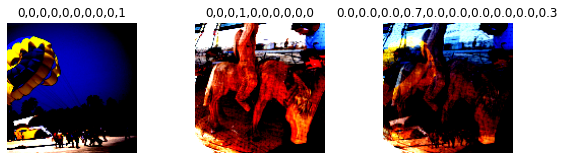

In [42]:
# 이런식으로 재구성됨
x,y = dls.one_batch()
x1 = x[0].cpu()
x1 = np.transpose(x1,(1,2,0))
x2 = x[1].cpu()
x2 = np.transpose(x2,(1,2,0))
y1 = y[0].cpu()
y2 = y[1].cpu()
one_hot_vec_y1 = np.array([0]*10)
one_hot_vec_y2 = np.array([0]*10)
one_hot_vec_y1[y1] = 1
one_hot_vec_y2[y2] = 1

# 랜덤하게 생성
t=0.3

fig,ax = plt.subplots(1,3, figsize=(8,4))
ax[0].imshow(x1)
ax[0].set_title(','.join(list(map(str,one_hot_vec_y1))), fontsize=12)
ax[0].axis('off')

ax[1].imshow(x2)
ax[1].set_title(','.join(list(map(str,one_hot_vec_y2))),fontsize=12)
ax[1].axis('off')

ax[2].imshow(x1*t + x2*(1-t))
ax[2].set_title(','.join(list(map(str,one_hot_vec_y1*t + one_hot_vec_y2*(1-t)))),fontsize=12)
ax[2].axis('off')
plt.tight_layout()

In [45]:
# learner에 callback을 더해 믹스업을 내부적으로 처리시킬 수 있음
# (callback : 학습 루프 내의 사용자 정의 행동을 주입하는 수단)
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=MixUp())
learn.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.885596,3.747154,0.325616,02:14
1,1.676519,1.530062,0.509709,02:14
2,1.460392,1.177643,0.634055,02:13
3,1.306878,0.790172,0.761389,02:15
4,1.198939,0.717866,0.785661,02:16


이렇게 혼합된(mixed up) 데이터로 모델을 학습시키면 겹친 이미지 때문에 학습이 오히려 더 어려워진다. <- 이미지마다 두 레이블을 예측해야만 하고, 각각 어느 정도의 가중치가 매겨졌는지도 알아내야한다.<br>
하지만 에포크마다 같은 이미지가 아니라 임의의 조합으로 구성된 두 이미지를 보여주므로 과적합 문제가 발생할 가능성은 낮아진다.

믹스업으로 정확도를 개선하려면 학습에 보다 많은 에포크가 소요된다.

## 레이블 평활화
레이블 평활화 : 분류 문제에서 모든 1을 1보다 약간 작은 수로 바꾸고 0을 0보다 약간 큰 수로 바꾼 다음 학습해볼 수 있다. 이런 방식을 통해 모델의 신뢰도를 낮춤으로써 레이블링이 잘못된 데이터가 있더라도 학습을 더욱 견고하게 만들어준다. (추론시 일반화가 더 잘된 모델을 얻게된다.)

(Overfitting과 Overconfidence에 유용)

0 -> $N/\epsilon$,  $N$: 범주의 개수, $\epsilon$: 작은 수(일반적으로 0.1)<br>
1 -> $1-\epsilon + {\epsilon\over{N}}$

In [ ]:
# 실제로는 원핫 인코딩을 사용할 필요가 없다.
# learner 생성시 손실 함수 부분만 바꿔주면 됨
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.fit_one_cycle(5,3e-3)